In [1]:
%pylab inline
import os
import sys
import pickle
import feather
import numpy as np
import pandas as pd
import scanpy as sc
#sys.path.append('../seq/')
#import rnaseqTools

from matplotlib import *
import matplotlib.pyplot as plt
rcParams['pdf.fonttype']=42 # in order to save fonttype in AI
rcParams['ps.fonttype']=42

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# create the color table for neuron clusters.
clusterColors_NeuronTable=np.array([ '#98A14E',   #0
                                    '#008000',    #1
                                    '#2E8B57',     #2
                                    '#96C390',     #3
                                    '#6FBC1E',    #4
                                    '#6D9269',    #5
                                    '#90EE90',    #6
                                    '#224700',   #7  
                                    '#228B22',  # 8
                                    '#00FF7F',     #9
                                    '#ADD8E6',  #'#7CFC00',#  10
                                    '#4666A6',    # 11
                                    '#1E90FF', #'#7FFF00',  #12
                                    '#B4BA77',     #13
                                    '#1B655D',    #14
                                    '#008B8B',    #15
                                    '#00CED1',    #16
                                    '#20B2AA',    #17
                                    '#66CDAA',     #18
                                    '#00FF00',    #19    ### greenish colors for excitatory neurons 
                              
                              '#DDACC9', '#DEB887', '#DD8091', '#7C086C', '#FFD700', '#FF8C97',    #20-25
                              '#FFA388', '#C77963', '#7E0ACB', '#FF4500', '#FF0000', '#9900B3',    #26-31
                              '#C9AE9C', '#AA4DB5', '#FF1493', '#AB1DFF', '#FF5FCD', '#FFC0CB',
                              '#B09FFF', '#DAA520', '#992E81', '#F70CF3', '#FFBF09', '#AB379C',
                              '#F5DEB3', '#7779BF', '#626EB8', '#FFFF00', '#FF8011', '#FF9F2C',
                              '#FF88AD', '#C22B74', '#FFB22B', '#D9C566', '#BE8652',     ### redish colors for inhibttory neurons.
                              ])

In [3]:
# elecFeatTable = './data_ephy/data_ephyio_ins.csv'
elecFeatTable = './data_ephy/Ins_patchseq_ephs.xlsx'
rawElecFeatures = pd.read_excel(elecFeatTable,'Ins_patchseq_ephs',index_col='cDNA_ID')

In [4]:
rawElecFeatures = rawElecFeatures[~isnan(rawElecFeatures['predictCluster'])]
rawElecFeatures

,Cell_ID,cellType,predictCluster,Tau_ms,Sag_Ratio,Rm_MO,RMP_mV,Rheobase_pA,Spike_Latency_ms,Threshold_mV,...,ISI_phaseT_ratio_CV,latency_slope,FR_slope,firstISI_slope,ISI_adpIdx_slope,ampAdpIdx_slope,firstSpikePhaseArea,firstSpikePhasePerimeter,spikePhaseAreaRatio,spikePhasePerimeterRatio
cDNA_ID,,,,,,,,,,,,,,,,,,,,,
s170,VEN_M_0730_C1_0000_fp_CH1,NaN,18,43.492,1.077,115.514,-65.323,140.0,160.66,-39.984,...,0.379,0.167,0.012,-0.210,2.377,0.1125,8906.444,568.273,3.535,1.794
s173,VEN_M_0730_C5_0000_fp_CH1,VEN_Long,16,33.006,1.311,88.803,-65.951,40.0,211.50,-55.373,...,0.628,0.397,0.054,-0.474,-3.885,-0.7318,13018.269,684.670,4.735,2.021
s174,VEN_M_0730_C6_0002_fp_CH1,VEN_Long,16,58.708,1.312,146.022,-58.827,20.0,402.36,-44.213,...,0.428,0.237,0.049,-0.944,1.083,-0.9584,11271.623,643.577,4.197,1.920
s175,VEN_M_0730_C7_0002_fp_CH1,PC_L5,18,55.866,1.152,159.960,-64.555,100.0,230.20,-38.491,...,0.386,0.187,0.031,-0.599,2.695,-0.3943,5758.154,466.527,4.386,1.929
s177,VEN_M_0730_C9_0000_fp_CH1,NaN,14,26.871,1.064,148.930,-55.866,180.0,144.06,-16.784,...,0.581,0.133,0.051,-0.346,28.019,-13.3033,10269.045,611.233,5.556,2.227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n191,20220429VENHS03C10_CH1,PC_L5,14,23.672,1.068,161.129,-57.289,80.0,74.92,-35.989,...,0.148,0.579,0.081,-0.946,1.574,-0.1229,11880.731,660.252,3.821,1.901
n193,20220429VENHS03C11_CH1,L23_PC,15,23.377,1.145,256.807,-69.698,20.0,249.40,-50.287,...,0.211,0.595,0.167,-1.111,3.623,-0.9982,13609.246,701.057,7.839,2.831
n197,20220429VENHS03C12_CH1,L23_PC,15,26.777,1.113,203.829,-66.974,80.0,110.20,-37.927,...,0.317,0.415,0.083,-1.061,1.387,-1.3230,14299.362,724.031,9.800,3.123


In [5]:
predictCluster = rawElecFeatures.loc[:,'predictCluster']
rawElecFeatures.loc[:,'predictCluster'] = rawElecFeatures['predictCluster'].astype(int)

In [6]:
rawElecFeatures.columns

Index(['Cell_ID', 'cellType', 'predictCluster', 'Tau_ms', 'Sag_Ratio', 'Rm_MO',
       'RMP_mV', 'Rheobase_pA', 'Spike_Latency_ms', 'Threshold_mV',
       'AP_Amplitute', 'AHP_mV', 'Rise_phase_Time_ms', 'Decay_phase_Time_ms',
       'Half_Width_ms', 'Max_Spike_Number', 'MaxFiringRate', 'Rebound_mV',
       'ReboundSpike', 'aveAPwidth_maxSweep', 'RisDecayTRatio', 'AHP_latency',
       'AP_widthRatio', 'amp_ratio', 'ampAdaptIdx', 'amp_FanoFactor', 'amp_CV',
       'ISI_FanoFactor', 'ISI_adpIdx', 'ISI_ratio', 'ISI_CV',
       'ISI_phaseT_ratio', 'ISI_phaseT_ratio_CV', 'latency_slope', 'FR_slope',
       'firstISI_slope', 'ISI_adpIdx_slope', 'ampAdpIdx_slope',
       'firstSpikePhaseArea', 'firstSpikePhasePerimeter',
       'spikePhaseAreaRatio', 'spikePhasePerimeterRatio'],
      dtype='object')

In [7]:
featureNames = rawElecFeatures.columns[10:]

In [8]:
plot_features = ['Tau_ms', 'Sag_Ratio', 'Rm_MO', 'RMP_mV', 'Rheobase_pA',
       'Spike_Latency_ms', 'Threshold_mV', 'AP_Amplitute', 'AHP_mV',
       'Rise_phase_Time_ms', 'Decay_phase_Time_ms', 'Half_Width_ms',
       'MaxFiringRate', 'Rebound_mV', 'ReboundSpike',
       'aveAPwidth_maxSweep', 'RisDecayTRatio', 'AHP_latency', 'AP_widthRatio',
       'amp_ratio', 'ampAdaptIdx', 
       'ISI_FanoFactor',  'ISI_CV',
       'ISI_phaseT_ratio', 'ISI_phaseT_ratio_CV', 'latency_slope', 'FR_slope',
       'firstISI_slope', 'ISI_adpIdx_slope', 'ampAdpIdx_slope',
       'firstSpikePhaseArea', 'firstSpikePhasePerimeter',
       'spikePhaseAreaRatio', 'spikePhasePerimeterRatio']

clusterNames = ['Exc RORB SCN7A', 'Exc HPCAL1 MEPE', 'Exc RORB CDK2AP1',
                 'Exc FEZF2 RSPO3', 'Exc FEZF2 SMYD1', 'Exc HPCAL1 FREM3', 
                 'Exc FEZF2 LTBP3', 'Exc RORB CYP26B1', 'Exc FEZF2 COL24A1',
                 'Exc RORB DEPTOR', 'Exc FEZF2 HTR2C', 'Exc RORB CHI3L1', 
                 'Exc HPCAL1 FRZB', 'Exc RORB FAP', 'Exc RORB NRG1',
                 'Exc HPCAL1 PENK', 'Exc FEZF2 DSG2', 'Exc HPCAL1 KANK4',
                 'Exc FEZF2 MCUB',  'Exc RORB TRDN ',
                
                 'Inh VIP SCNG', 'Inh SST PENK', 'Inh SST MME', 'Inh LAMP5 RGCC',
                 'Inh SST ANXA2', 'Inh VIP SHISA8', 'Inh VIP SMOC1', 'Inh VIP RASL10A',
                 'Inh SST PTK2B', 'Inh LAMP5 IL13RA1', 'Inh PVALB PVALB',
                 'Inh LAMP5 BCAM', 'Inh VIP CRISPLD1', 'Inh SNCG IGFBP2',
                 'Inh PVALB COL5A2', 'Inh LAMP5 GSTM2', 'Inh LAMP5 BMP2', 
                 'Inh SNCG ARHGAP18', 'Inh SNCG PIK3CG', 'Inh SNCG PDLIM5', 
                 'Inh SST SP5', 'Inh SNCG S100A6', 'Inh SNCG ADRA1D', 'Inh SNCG CDH24', 
                 'Inh SST SLC30A3', 'Inh SNCG KLHL13', 'Inh SERPINF1 DCN', 
                 'Inh SNCG TPM2', 'Inh SNCG C1QL2', 'Inh LAMP5 SERPINF1',
                 'Inh PVALB NKX2-1', 'Inh SST CHODL', 'Inh VIP SLIT1']

In [9]:
dt = rawElecFeatures[plot_features]
dt.shape

(277, 34)

In [10]:
X = np.array(dt.copy())
cellnames_all = dt.index
ephysioFeatures = dt.columns

In [11]:
print(X.shape)

(277, 34)


In [12]:
keepcells = ~np.isnan(predictCluster)

X = X[keepcells, :]
cellnames = dt.index[keepcells]
predictCluster = predictCluster[keepcells]

14


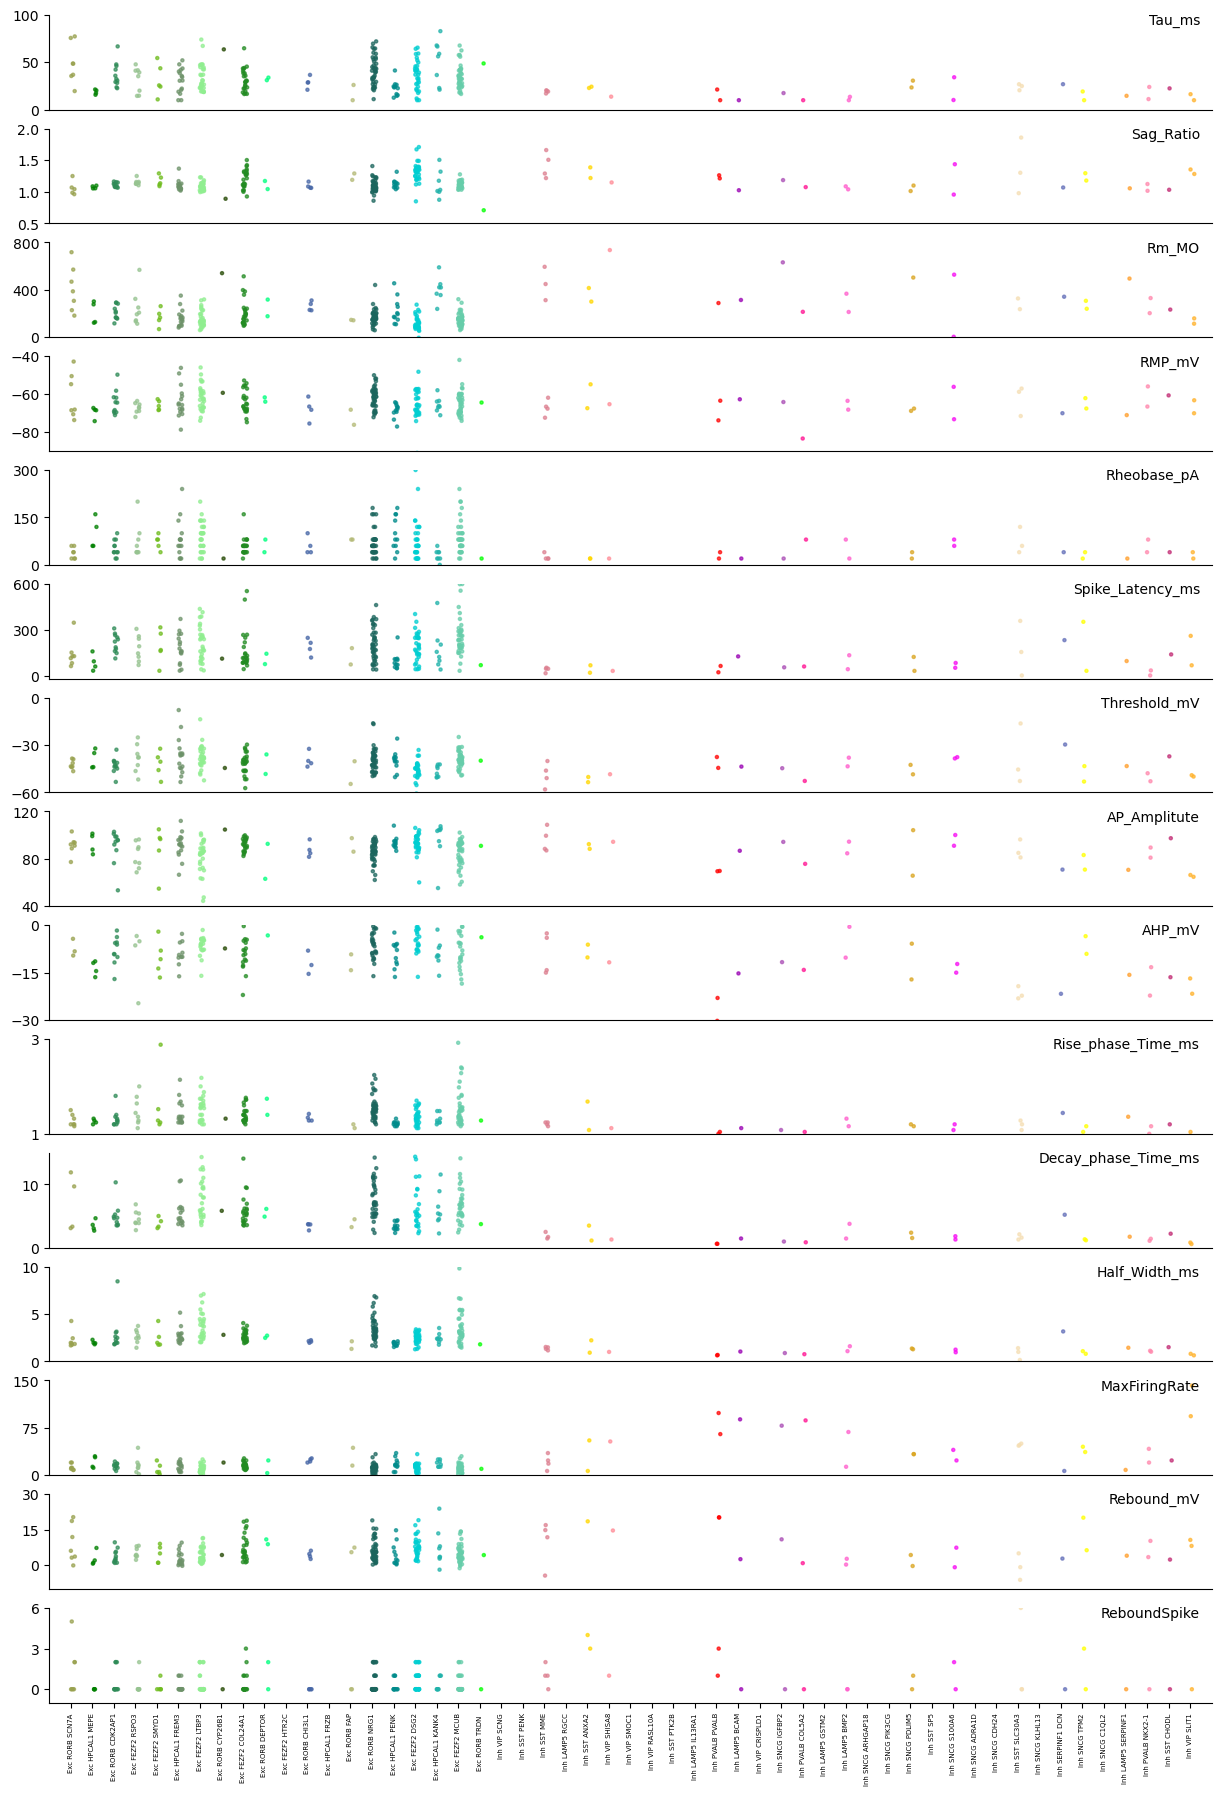

In [13]:
fig = plt.figure( figsize=(15, 50) )

x_axis = np.ones(X.shape[0])
dotsize = 20
nFeatures = X.shape[1]
nCluster = 53

n=0
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([0,100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([0.5,2])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([0,800])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,400,800])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([-90,-40])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([0,300])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,150,300])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([-20,600])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,300,600])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([-60,0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([-60,-30,0])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)    


n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([40,120])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([40,80,120])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)    

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([-30,0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([-30,-15,0])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)      

    
n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([1,3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([1,3])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)  

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([0,15])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,10])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)     

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([0,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,5,10])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)     

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([0,150])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,75,150])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)     

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([-10,30])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,15,30])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)  

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([-1,6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,3,6])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)      
plt.xticks(range(nCluster), clusterNames, rotation=90, fontsize=5)

    
print(n)

plt.savefig('./figures/ephyFeatCmp_byCluster1.png',dpi=600);
plt.savefig('./figures/ephyFeatCmp_byCluster1.pdf');

28


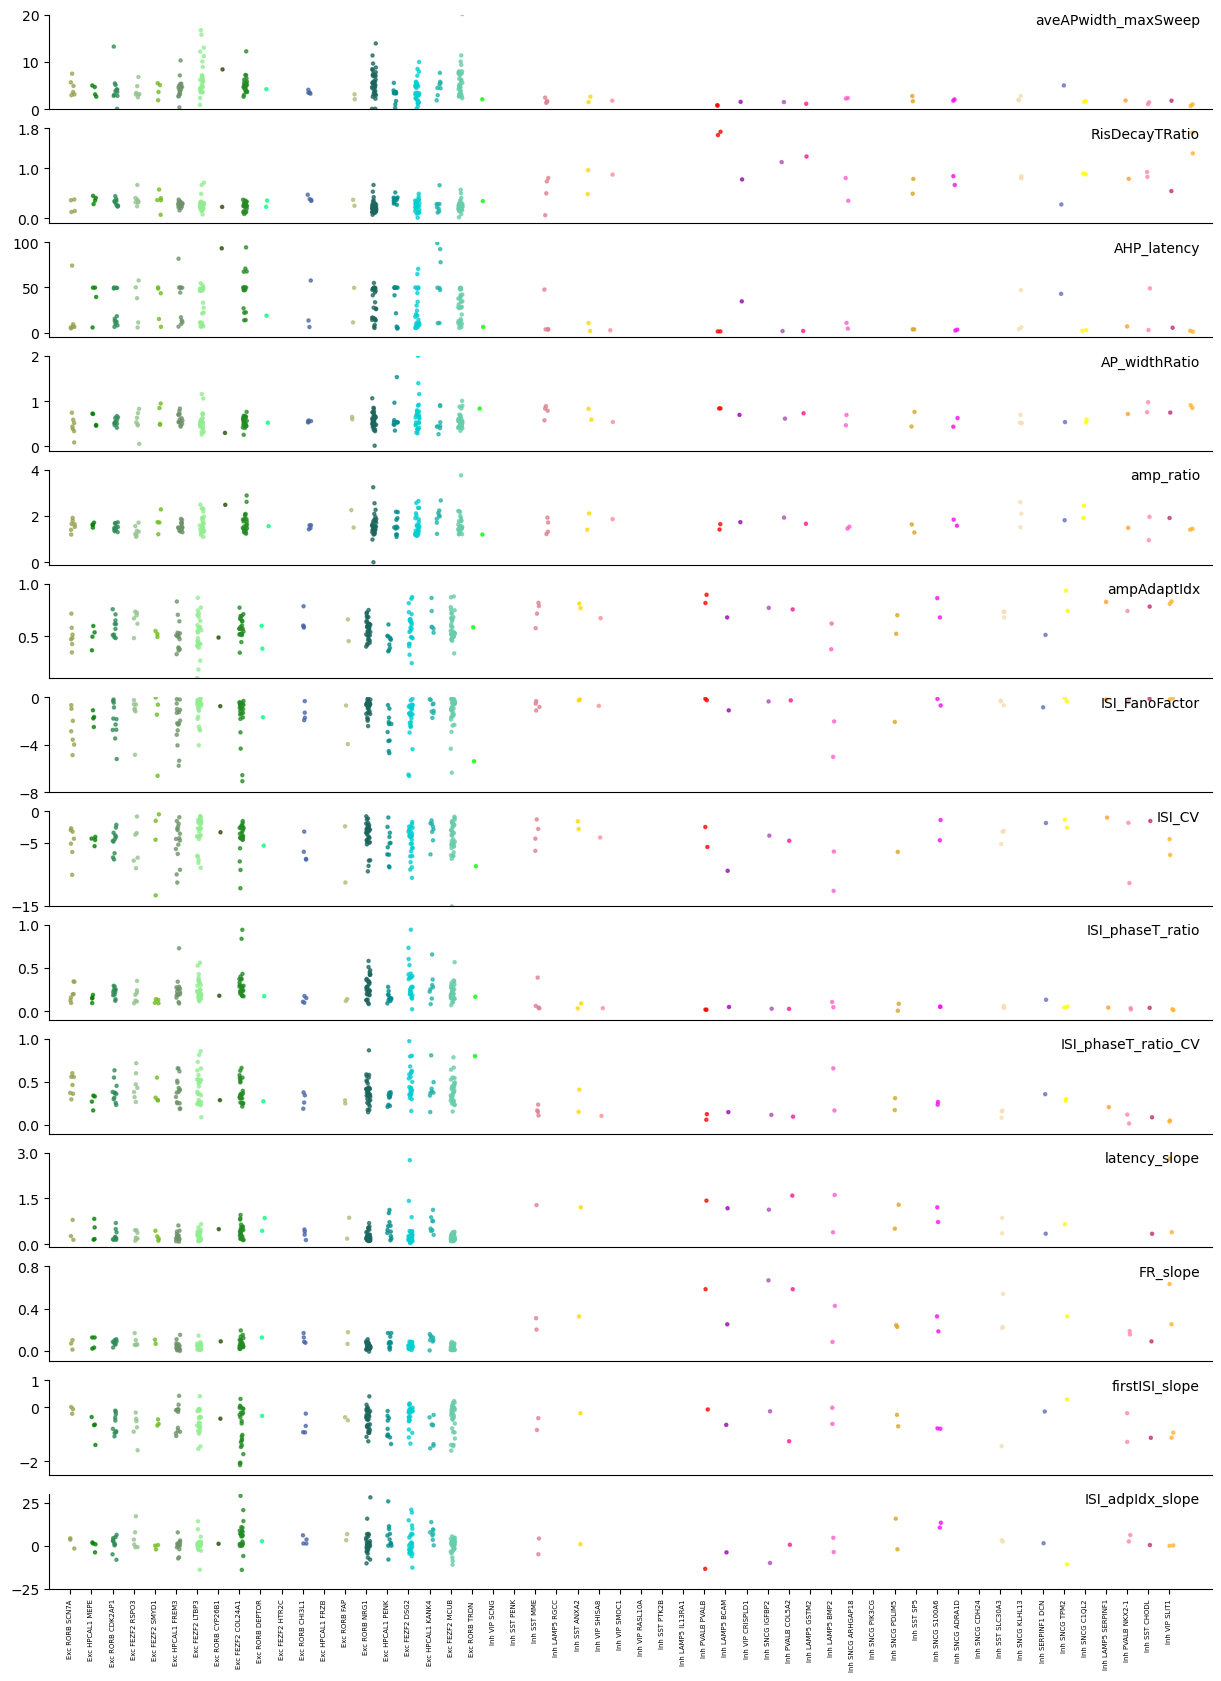

In [14]:
fig = plt.figure( figsize=(15, 50) )

n=15
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([0,20])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,10,20])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)          

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([-0.10,1.8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,1.0,1.8])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)     

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([-5,100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,50,100])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)       

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([-0.10,2])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,1,2])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)   

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,53])
ax.set_ylim([-0.10,4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,2,4])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)  
    
n=n+1    
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,54])
ax.set_ylim([0.10,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
# plt.yticks([0,3,6])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)     

n=n+1       
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,54])
ax.set_ylim([-8,0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([-8,-4,0])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)      

n=n+1      
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.') 
ax.set_xlim([-1,54])
ax.set_ylim([-15,0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([-15,-5,0])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)       

n=n+1 
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,54])
ax.set_ylim([-0.1,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,0.5,1])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)  

n=n+1     
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,54])
ax.set_ylim([-0.1,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,0.5,1])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)      

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,54])
ax.set_ylim([-0.1,3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,1.5,3])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)       

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,54])
ax.set_ylim([-0.1,0.8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,0.4,0.8])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)   

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,54])
ax.set_ylim([-2.5,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([-2,0,1])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)   

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,54])
ax.set_ylim([-25,30])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([-25,0,25])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10) 
plt.xticks(range(nCluster), clusterNames, rotation=90, fontsize=5)
    
    
print(n)

plt.savefig('./figures/ephyFeatCmp_byCluster2.png',dpi=600);
plt.savefig('./figures/ephyFeatCmp_byCluster2.pdf');

33


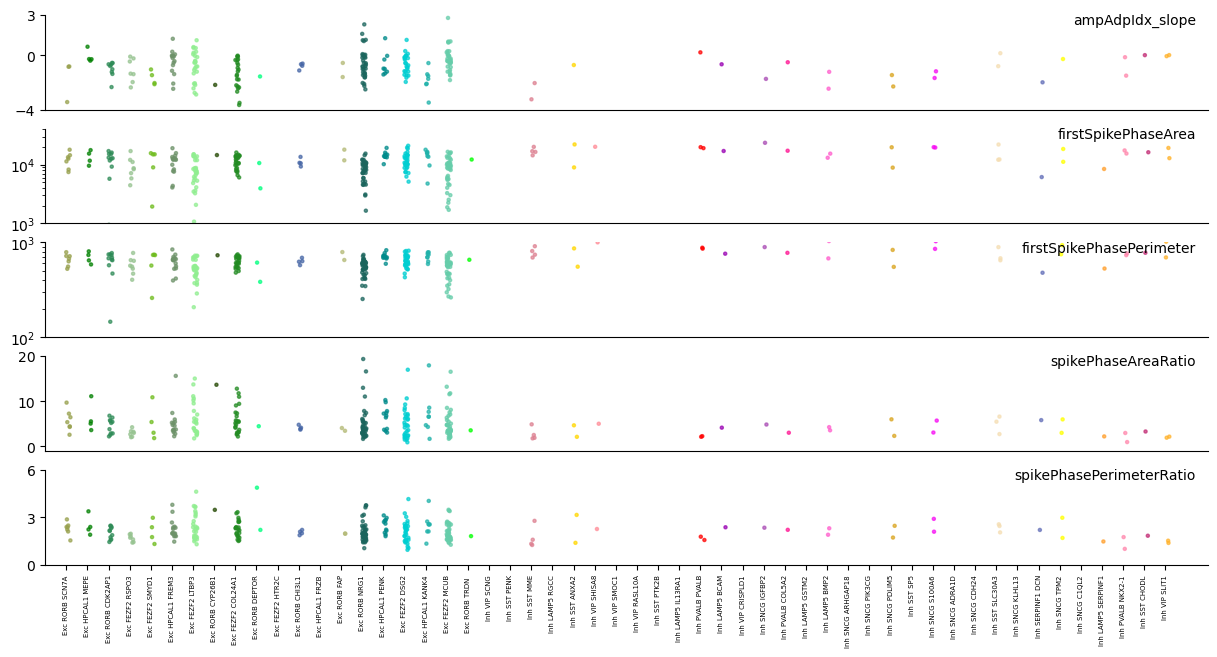

In [15]:
fig = plt.figure( figsize=(15, 50) )

n=29
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,54])
ax.set_ylim([-3,3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([-4,0,3])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)  
    
n=n+1    
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,54])
ax.set_ylim([1000,41000])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
# plt.yticks([-4,0,3])
plt.yscale('log')
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)       
    
n=n+1    
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,54])
ax.set_ylim([100,1001])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([100,500,1000])
plt.yscale('log')
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)  

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,54])
ax.set_ylim([-1,20])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,10,20])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10)  

n=n+1
ax = plt.subplot(nFeatures,1,n+1)
x = predictCluster+np.random.rand(np.sum(  predictCluster.count() ))/5
c= clusterColors_NeuronTable[predictCluster]
scatter = ax.scatter(x,X[:, n], c= clusterColors_NeuronTable[predictCluster], alpha = 0.7,s=dotsize, marker='.')
ax.set_xlim([-1,54])
ax.set_ylim([0,6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([0,3,6])
plt.text(0.99, 0.9, plot_features[n],transform=ax.transAxes,ha='right',fontsize=10) 
plt.xticks(range(nCluster), clusterNames, rotation=90, fontsize=5)
    
    
print(n)

plt.savefig('./figures/ephyFeatCmp_byCluster3.png',dpi=600);
plt.savefig('./figures/ephyFeatCmp_byCluster3.pdf');